# GAN in TensorFlow 2.0

출처 : https://github.com/MonteChristo46/GAN-Notebooks/blob/master/GAN.ipynb

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

print(tf.__version__)

2.0.0


## Global Parameters

In [2]:
BATCH_SIZE = 256
BUFFER_SIZE = 60000
EPOCHES = 1000

## Loading the MNIST dataset

In [3]:
mnist = keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images.shape

(60000, 28, 28)

### Adding the Data to tf.Dataset

In [4]:
train_images = train_images.astype("float32")
train_images = (train_images - 127.5) / 127.5

# data를 tensor에 넣음. (60000,28,28) -> (60000,784)로 reshape. 배치사이즈마다 데이터가 셔플됨.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images.reshape(train_images.shape[0],784)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generator Network

In [5]:
class Generator(keras.Model):
    
    def __init__(self, random_noise_size = 100):
        super().__init__(name='generator')
        # layers 만듦
        self.input_layer = keras.layers.Dense(units = random_noise_size)
        self.dense_1 = keras.layers.Dense(units = 128)
        self.leaky_1 =  keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_2 = keras.layers.Dense(units = 128)
        self.leaky_2 = keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_3 = keras.layers.Dense(units = 256)
        self.leaky_3 = keras.layers.LeakyReLU(alpha = 0.01)
        self.output_layer = keras.layers.Dense(units=784, activation = "tanh")
        
    def call(self, input_tensor):
        # layer에 인풋 아웃풋 넣어서 순서대로 통과하게 만듦
        x = self.input_layer(input_tensor)
        x = self.dense_1(x)
        x = self.leaky_1(x)
        x = self.dense_2(x)
        x = self.leaky_2(x)
        x = self.dense_3(x)
        x = self.leaky_3(x)
        return  self.output_layer(x)
    
    # 랜덤 노이즈 생성
    def generate_noise(self,batch_size, random_noise_size):
        return np.random.uniform(-1,1, size = (batch_size, random_noise_size))

### Objective Function

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generator_objective(dx_of_gx):
    # generator는 진짜 이미지라고 속여야 하기 떄문에 1매트릭스와 이미지를 비교해서 1에 가깝게 만듦
    return cross_entropy(tf.ones_like(dx_of_gx), dx_of_gx) 

generator = Generator()

## Discriminator Network

In [10]:
class Discriminator(keras.Model):
    def __init__(self):
        super().__init__(name = "discriminator")
        
        # Layers 만듦
        self.input_layer = keras.layers.Dense(units = 784)
        self.dense_1 = keras.layers.Dense(units = 128)
        self.leaky_1 =  keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_2 = keras.layers.Dense(units = 128)
        self.leaky_2 = keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_3 = keras.layers.Dense(units = 128)
        self.leaky_3 = keras.layers.LeakyReLU(alpha = 0.01)
        # output은 숫자 하나가 나와서 진짜인지 가짜인지 판별
        self.logits = keras.layers.Dense(units = 1)  
        
    def call(self, input_tensor):
        # layer에 인풋 아웃풋 넣어서 순서대로 통과하게 만듦
        x = self.input_layer(input_tensor)
        x = self.dense_1(x)
        x = self.leaky_1(x)
        x = self.leaky_2(x)
        x = self.leaky_3(x)
        x = self.leaky_3(x)
        x = self.logits(x)
        return x

In [11]:
discriminator = Discriminator()

### Objective Function

In [12]:
def discriminator_objective(d_x, g_z, smoothing_factor = 0.9):
    """
    d_x = real output
    g_z = fake output
    """
    # 진짜 이미지는 1에 가깝게 학습, 가짜 이미지는 0에 가깝게 학습.
    real_loss = cross_entropy(tf.ones_like(d_x) * smoothing_factor, d_x) 
    fake_loss = cross_entropy(tf.zeros_like(g_z), g_z) 
    
    # 진짜이미지 loss와 가짜이미지 loss 합쳐서 loss로 정의
    total_loss = real_loss + fake_loss
    
    return total_loss

## Optimizer

In [13]:
generator_optimizer = keras.optimizers.RMSprop()
discriminator_optimizer = keras.optimizers.RMSprop()

## Training Functions

In [14]:
@tf.function()
def training_step(generator: Discriminator, discriminator: Discriminator, images:np.ndarray , k:int =1, batch_size = 32):
    for _ in range(k):
         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # 노이즈 생성, generator에 input으로 넣음
            noise = generator.generate_noise(batch_size, 100)
            g_z = generator(noise)
            
            # discriminator에 실제 이미지와, generator가 생성한 가짜 이미지 넣음
            d_x_true = discriminator(images)
            d_x_fake = discriminator(g_z)

            discriminator_loss = discriminator_objective(d_x_true, d_x_fake)
            
            # gradient 조정하면서 학습
            gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
            # gradient와 학습 파라미터를 가져와서 optimizer 돌림
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) 
            
              
            # fake image를 discriminator가 1로 학습하도록 함 
            generator_loss = generator_objective(d_x_fake)
            # generator 학습
            gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
            # gradient와 학습 파라미터를 가져와서 optimizer 돌림
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) 
    

In [15]:
# 출력을 위한 노이즈 생성
seed = np.random.uniform(-1,1, size = (1, 100)) 

In [16]:
def training(dataset, epoches):
    for epoch in range(epoches):
        for batch in dataset: 
            training_step(generator, discriminator, batch ,batch_size = BATCH_SIZE, k = 1)
            
        ## After ith epoch plot image 
        if (epoch % 50) == 0: 
            fake_image = tf.reshape(generator(seed), shape = (28,28))
            print("{}/{} epoches".format(epoch, epoches))
            plt.imshow(fake_image, cmap = "gray")
#             plt.imsave("{}/{}.png".format(OUTPUT_DIR,epoch),fake_image, cmap = "gray")

0/1000 epoches
50/1000 epoches
100/1000 epoches
150/1000 epoches
200/1000 epoches
250/1000 epoches
300/1000 epoches
350/1000 epoches
400/1000 epoches
450/1000 epoches
500/1000 epoches
550/1000 epoches
600/1000 epoches
650/1000 epoches
700/1000 epoches
750/1000 epoches
800/1000 epoches
850/1000 epoches
900/1000 epoches
950/1000 epoches
CPU times: user 21min 54s, sys: 3min 44s, total: 25min 38s
Wall time: 24min 24s


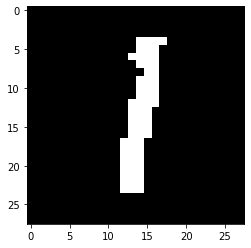

In [17]:
%%time
training(train_dataset, EPOCHES)

## Testing the Generator

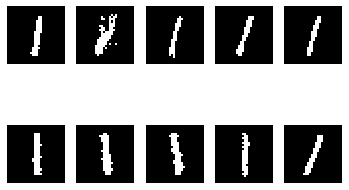

In [24]:
fake_image = generator(np.random.uniform(-1,1, size = (10, 100)))

r, c = 2, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(tf.reshape(fake_image[cnt], shape = (28,28)), cmap="gray")
        axs[i,j].axis('off')
        cnt += 1